## (Final) Deep Learning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime
from sklearn.linear_model import LogisticRegression

In [4]:
data=pd.read_csv("./final_project_data.csv")
data=data.dropna()
data.index=range(len(data))

In [5]:
data.shape

(3547259, 43)

In [20]:
i=2012
train=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i-4)+'0101'))]
train=train.dropna()
train.index=range(len(train))
    #globals()['train_{}'.format(i)]=train.copy()
    
test=data[(data.date<=int(str(i+1)+'1231'))&(data.date>=int(str(i+1)+'0101'))]
test=test.dropna()
test.index=range(len(test))
    #globals()['test_{}'.format(i)]=test.copy() 
    
X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
Y_train=np.asarray(train.loc[:,'target'])
    
X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
Y_test=np.asarray(test.loc[:,'target'])

a=X_train.shape[0]*1/10
X_valid, X_train = X_train[:a], X_train[a:]
Y_valid, Y_train = Y_train[:a], Y_train[a:]




In [23]:
X_train.shape

(1468649, 33)

## Deep Learning
- mimic the paper's neural networks

In [8]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [9]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [10]:
def logit(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [12]:
def relu(z, alpha=1):
        return np.where(z<0, 0, z)

In [73]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

### Tuning

#### Test 1
- tuning batch size

In [13]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 5
batch_size = 32
batch_norm_momentum = 0.9

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


In [24]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)


(0, 'Validation accuracy:', 0.5048075)
(1, 'Validation accuracy:', 0.5019334)
(2, 'Validation accuracy:', 0.50542027)
(3, 'Validation accuracy:', 0.50436014)
(4, 'Validation accuracy:', 0.50506485)


#### Test 2
- tuning batch size

In [25]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 5
batch_size = 128
batch_norm_momentum = 0.9

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

(0, 'Validation accuracy:', 0.5058186)
(1, 'Validation accuracy:', 0.4981585)
(2, 'Validation accuracy:', 0.5083557)
(3, 'Validation accuracy:', 0.5000092)
(4, 'Validation accuracy:', 0.5069952)


#### Test 3
- tuning learning rate

In [29]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 5
batch_size = 32
batch_norm_momentum = 0.9

learning_rate = 0.05

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [30]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

(0, 'Validation accuracy:', 0.505359)
(1, 'Validation accuracy:', 0.49951893)
(2, 'Validation accuracy:', 0.5002482)
(3, 'Validation accuracy:', 0.50255233)
(4, 'Validation accuracy:', 0.50360024)


#### Test 4
- tuning batch_norm_momentum

In [31]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 5
batch_size = 32
batch_norm_momentum = 0.99

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

(0, 'Validation accuracy:', 0.50477684)
(1, 'Validation accuracy:', 0.50349605)
(2, 'Validation accuracy:', 0.5055183)
(3, 'Validation accuracy:', 0.5036738)
(4, 'Validation accuracy:', 0.50614953)


#### Test 5 
- Tuning n_epochs

In [34]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 20
batch_size = 32
batch_norm_momentum = 0.99

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

(0, 'Validation accuracy:', 0.50477684)
(1, 'Validation accuracy:', 0.50349605)
(2, 'Validation accuracy:', 0.5055183)
(3, 'Validation accuracy:', 0.5036738)
(4, 'Validation accuracy:', 0.50614953)
(5, 'Validation accuracy:', 0.5050465)
(6, 'Validation accuracy:', 0.5065356)
(7, 'Validation accuracy:', 0.5026933)
(8, 'Validation accuracy:', 0.50820243)
(9, 'Validation accuracy:', 0.5040415)
(10, 'Validation accuracy:', 0.5005239)
(11, 'Validation accuracy:', 0.50395566)
(12, 'Validation accuracy:', 0.50763255)
(13, 'Validation accuracy:', 0.5031774)
(14, 'Validation accuracy:', 0.50250334)
(15, 'Validation accuracy:', 0.50472784)
(16, 'Validation accuracy:', 0.5035696)
(17, 'Validation accuracy:', 0.50048107)
(18, 'Validation accuracy:', 0.50165766)
(19, 'Validation accuracy:', 0.5051261)


#### THE RESULT model

In [55]:
from functools import partial

reset_graph()

n_inputs = 33  # data
n_hidden1 = 40
n_hidden2 = 4
n_hidden3 = 50
n_outputs = 2

n_epochs = 5
batch_size = 32
batch_norm_momentum = 0.99

learning_rate = 0.01




X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.relu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.relu(my_batch_norm_layer(hidden2))
    hidden3 = my_dense_layer(bn2, n_hidden3, name="hidden3")
    bn3 = tf.nn.relu(my_batch_norm_layer(hidden3))
    
    
    
    logits_before_bn = my_dense_layer(bn3, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "./my_model_final.ckpt")

(0, 'Validation accuracy:', 0.50366765)
(1, 'Validation accuracy:', 0.5039618)
(2, 'Validation accuracy:', 0.5053222)
(3, 'Validation accuracy:', 0.5064314)
(4, 'Validation accuracy:', 0.50320804)


In [41]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [43]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", Y_test[:20])

('Predicted classes:', array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]))
('Actual classes:   ', array([1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 0.]))


#### Train

In [82]:
for i in range (2012,2013):
    train=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i-4)+'0101'))]
    train=train.dropna()
    train.index=range(len(train))
    #globals()['train_{}'.format(i)]=train.copy()
    
    test=data[(data.date<=int(str(i+1)+'1231'))&(data.date>=int(str(i+1)+'0101'))]
    test=test.dropna()
    test.index=range(len(test))
    #globals()['test_{}'.format(i)]=test.copy() 
    
    X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_train=np.asarray(train.loc[:,'target'])
    
    X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_test=np.asarray(test.loc[:,'target'])
    
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
                sess.run([training_op, extra_update_ops],
                         feed_dict={training: True, X: X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
            print(epoch, "Validation accuracy:", accuracy_val)
        save_path = saver.save(sess, "./my_model_final.ckpt")
    
    #clf=DecisionTreeClassifier(criterion='gini', max_features='log2', max_depth=5)
    #clf.fit(X_train, Y_train)
    
    with tf.Session() as sess:
        saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
        X_new_scaled = X_train
        Z = logits.eval(feed_dict={X: X_new_scaled})
        y_predit_prob=softmax(Z,1) 
    

    res=pd.concat((train.loc[:,['id','date','target']], pd.DataFrame(y_predit_prob)),axis=1) 
    res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
    res.index=range(len(res))
    globals()["result_{}".format(i)]=res.copy()
    print("result_{}".format(i))

(0, 'Validation accuracy:', 0.5028465)
(1, 'Validation accuracy:', 0.5142325)
(2, 'Validation accuracy:', 0.5126698)
(3, 'Validation accuracy:', 0.49926156)
(4, 'Validation accuracy:', 0.50687265)
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
result_2012


In [77]:
for i in range (2012,2017):
    train=data[(data.date<=int(str(i)+'1231'))&(data.date>=int(str(i-4)+'0101'))]
    train=train.dropna()
    train.index=range(len(train))
    #globals()['train_{}'.format(i)]=train.copy()
    
    test=data[(data.date<=int(str(i+1)+'1231'))&(data.date>=int(str(i+1)+'0101'))]
    test=test.dropna()
    test.index=range(len(test))
    #globals()['test_{}'.format(i)]=test.copy() 
    
    X_train=np.asarray(train.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_train=np.asarray(train.loc[:,'target'])
    
    X_test=np.asarray(test.loc[:,'ret_raw_norm_lag_21':'isJan'])
    Y_test=np.asarray(test.loc[:,'target'])
    
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, Y_train, batch_size):
                sess.run([training_op, extra_update_ops],
                         feed_dict={training: True, X: X_batch, y: y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: Y_valid})
            print(epoch, "Validation accuracy:", accuracy_val)
        save_path = saver.save(sess, "./my_model_final.ckpt")
    
    #clf=DecisionTreeClassifier(criterion='gini', max_features='log2', max_depth=5)
    #clf.fit(X_train, Y_train)
    
    with tf.Session() as sess:
        saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
        X_new_scaled = X_test
        Z = logits.eval(feed_dict={X: X_new_scaled})
        y_predit_prob=softmax(Z,1)
    
    res=pd.concat((test.loc[:,['id','date','target']], pd.DataFrame(y_predit_prob)),axis=1)
    res.columns=["id","date",'target',"pred_zsprob_comp","Alp"]
    res.index=range(len(res))
    globals()["result_{}".format(i+1)]=res.copy()
    print("result_{}".format(i+1))

(0, 'Validation accuracy:', 0.50739354)
(1, 'Validation accuracy:', 0.5146308)
(2, 'Validation accuracy:', 0.51001024)
(3, 'Validation accuracy:', 0.51885307)
(4, 'Validation accuracy:', 0.5166163)
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
result_2013
(0, 'Validation accuracy:', 0.5125657)
(1, 'Validation accuracy:', 0.5114013)
(2, 'Validation accuracy:', 0.5081963)
(3, 'Validation accuracy:', 0.50538355)
(4, 'Validation accuracy:', 0.5112297)
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
result_2014
(0, 'Validation accuracy:', 0.5074671)
(1, 'Validation accuracy:', 0.5106721)
(2, 'Validation accuracy:', 0.5091952)
(3, 'Validation accuracy:', 0.5102431)
(4, 'Validation accuracy:', 0.5161322)
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
result_2015
(0, 'Validation accuracy:', 0.49961698)
(1, 'Validation accuracy:', 0.50388217)
(2, 'Validation accuracy:', 0.5051629)
(3, 'Validation accuracy:', 0.5084598)
(4, 'Validation accuracy:

In [83]:
RES=result_2012
for i in range(2013,2018):
    RES=pd.concat((RES,globals()["result_{}".format(i)]),axis=0)

tt=RES.merge(data.loc[:,["id","date","ret_raw","ret_20_raw","industry","flag2"]],left_on=["date","id"],right_on=["date","id"],how="left")

### Back Test Framework

To use this back-test framework, input a dataframe with date, alpha, ret=ret_20_raw, flag as your holding period, and keep the quantile cut at q=0.9.

In [79]:
def back_test(data,q=0.9,Alp="Alpha",flag="flag",date="date",ret="ret_raw",industry="industry",Id="id"):
    data=data[data.id!='GGP US Equity']
    data=data[data.industry!=7777]
    data=data[data.loc[:,flag]==True]
    data=data.loc[:,[date,Id,Alp,ret,industry]]
    data.columns=["Date","Id","Alp","Return","industry"]
    data.index=range(len(data))
    res=data.groupby(("Date")).apply(lambda x: x[x["Alp"]>=x["Alp"].quantile(q)].Return.mean()*0.5-
                          x[x["Alp"]<=x["Alp"].quantile(1-q)].Return.mean()*0.5)
    positions=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]>=x["Alp"].quantile(q))|(x["Alp"]<=x["Alp"].quantile(1-q))])

    long=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]>=x["Alp"].quantile(q))])
    short=data.groupby(("Date")).apply(lambda x: x[(x["Alp"]<=x["Alp"].quantile(1-q))])
    res=res.reset_index()
    res=res.dropna()
    res.index=range(len(res))

    globals()["res"]=res
    plt.figure(figsize=(20,10))
    plt.plot((res.iloc[:,-1]).cumsum())

    n=int(len(res)/30)+1
    plt.xticks(range(0,len(res),n),
               [str(res.loc[i,"Date"]).split(" ")[0] for i in range(0,len(res),n)],
               rotation=70,
              fontsize = 20)
    plt.yticks(fontsize=30)
    plt.axvline(x=len(res[res.Date<20121231]), c="r")

    plt.show()   
    return long,short,res

#### Compute Yearly Return and Sharpe Ratio

In [80]:
def summary_return_sharpe(res,period):
    res.loc[:,"year"]=(res.Date/10000).apply(int)
    Ret=res.groupby("year")[0].sum().reset_index()
    Y10T=0.021
    n=int(253/period)
    Fday=(Y10T+1)**(1/n)-1
    Sharpe=res.groupby("year")[0].apply(lambda x: (x).mean()/((x).std())*np.sqrt(n)).reset_index()
    Performance=Ret.merge(Sharpe,left_on="year",right_on="year",how="left")
    Performance.columns=["Year","Return","Sharpe"]
    return Performance

### DL Result

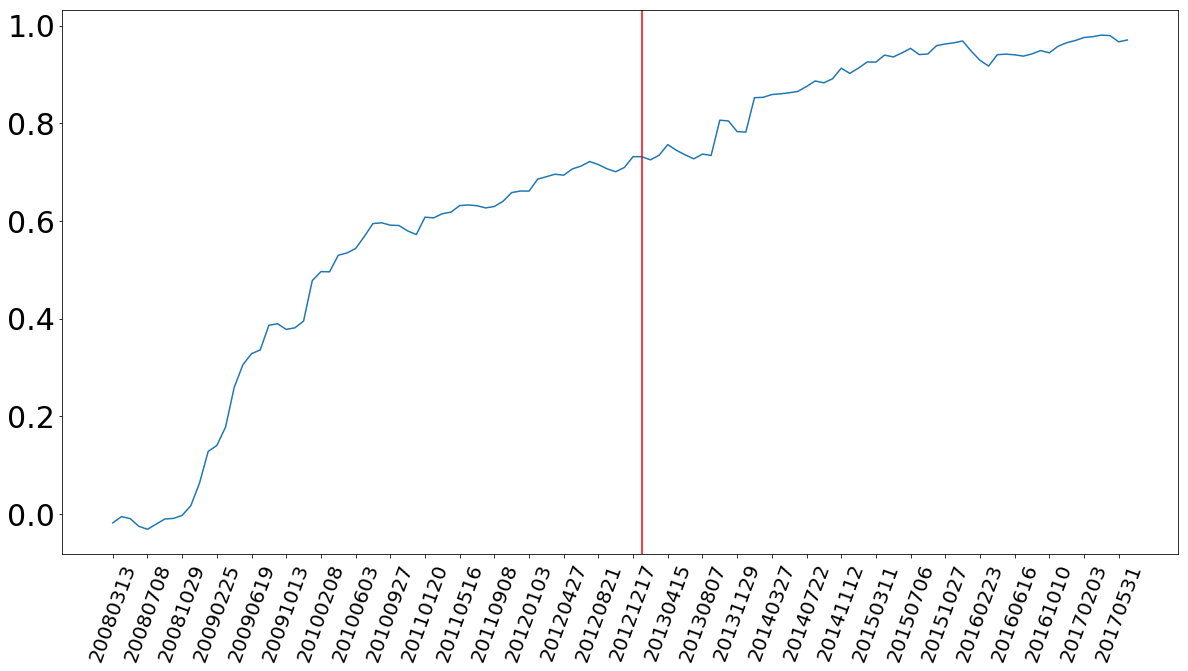

,Year,Return,Sharpe
0,2008,0.063239,1.468517
1,2009,0.331849,4.472902
2,2010,0.177063,2.491515
3,2011,0.089219,3.086127
4,2012,0.070403,2.408000
5,2013,0.050153,0.759244
6,2014,0.120306,2.220756
7,2015,0.066370,2.870436
8,2016,-0.003577,-0.106920
9,2017,0.005586,0.572646


In [84]:
a3=back_test(tt,q=0.90,flag="flag2",ret="ret_20_raw",Alp="Alp")
summary_return_sharpe(a3[2],12)